In [1]:
import os, io
import re, itertools
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:

NUM_SENTENCES = 20000 # Use only the first 20,000 records.
MAX_NUM_WORDS = 20000 # Use 20,000 words for tokenizing
MAX_SENT_LEN = 50

EMBEDDING_SIZE = 100

LSTM_NEURONS = 100

BATCH_SIZE = 64
EPOCHS = 10


In [ ]:
inputs = []
outputs_i = []
outputs = []
reference = []

data_file = open('/content/drive/MyDrive/spa.txt', encoding='utf-8')

count = 0
for line in data_file:
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    temp_op, ip, extra = line.rstrip().split('\t')
    op_i = '<sos> '+temp_op
    op = temp_op+' <eos>'
    ref = temp_op

    inputs.append(ip)
    outputs_i.append(op_i)
    outputs.append(op)
    reference.append(ref)

print('Total inputs =', len(inputs))
print('Total intermediate outputs =', len(outputs_i))
print('Total outputs =', len(outputs))
print('\nSample:')
print(inputs[100])
print(outputs_i[100])
print(outputs[100])
print(reference[100])

Total inputs = 20000
Total intermediate outputs = 20000
Total outputs = 20000

Sample:
¿Entendiste?
<sos> Got it?
Got it? <eos>
Got it?


In [ ]:
# tokenize inputs
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(inputs)

inputs_seq = input_tokenizer.texts_to_sequences(inputs)

inputs_word2index = input_tokenizer.word_index
print('Total unique words in input:', len(inputs_word2index))

inputs_numwords = len(inputs_word2index)+1

inputs_maxlen = max(len(s) for s in inputs_seq)
print('Length of longest sentence in input:', inputs_maxlen)

# tokenize output
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(outputs_i + outputs)


outputs_i_seq = output_tokenizer.texts_to_sequences(outputs_i)
outputs_seq = output_tokenizer.texts_to_sequences(outputs)

outputs_word2index = output_tokenizer.word_index
print('Total unique words in output:', len(outputs_word2index))

outputs_numwords = len(outputs_word2index)+1

outputs_maxlen = max(len(s) for s in outputs_seq)
print('Length of longest sentence in output:', outputs_maxlen)

Total unique words in input: 7908
Length of longest sentence in input: 9
Total unique words in output: 5427
Length of longest sentence in output: 6


In [ ]:
ref_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
ref_tokenizer.fit_on_texts(reference)

ref_seq = ref_tokenizer.texts_to_sequences(reference)

ref_word2index = ref_tokenizer.word_index
print('Total unique words in refrence:', len(ref_word2index))

ref_numwords = len(ref_word2index)+1

ref_maxlen = max(len(s) for s in ref_seq)
print('Length of longest sentence in input:', ref_maxlen)

Total unique words in refrence: 5425
Length of longest sentence in input: 5


In [ ]:
decoder_ref_sequences = pad_sequences(ref_seq, maxlen=ref_maxlen, padding='post')
print('refseq shape:', decoder_ref_sequences.shape)
for row in decoder_ref_sequences:
  print(row)

Streaming output truncated to the last 5000 lines.
[4659    3  241    0    0]
[ 18 497   3 660   0]
[ 18 497   3 194   0]
[ 18 497   3 194   0]
[ 18 848   3 718   0]
[ 18 246   3 160   0]
[  18  309 1768    0    0]
[  18  309 1768    0    0]
[ 18 900   3 248   0]
[ 18  57  14 317   0]
[ 18 705   3 160   0]
[  18    3  529 4660    0]
[  18    3    4 4661    0]
[  18    3    4 1663    0]
[  18    3 3075   19    0]
[  18    3   74 1700    0]
[  18    3   74 1700    0]
[  18    3 4662    0    0]
[ 18   3 359 883   0]
[  18    3 1957    0    0]
[  18    3 3076    0    0]
[  18    3   11 3077    0]
[  18    3   11 3077    0]
[ 18   3  11 373   0]
[ 18   3  11 822   0]
[ 18   3  11 310   0]
[ 18   3  11 934   0]
[  18    3   11 1161    0]
[  18    3   11 2580    0]
[  18    3 2890    0    0]
[ 18   3  28 499   0]
[  18    3   28 1187    0]
[ 18   3  28 465   0]
[ 18   3  28 216   0]
[ 18   3  28 216   0]
[ 18   3 172 100   0]
[ 18   3 172 100   0]
[ 18   3 172 392   0]
[  18    3 1683    0   

In [ ]:
encoder_input_sequences = pad_sequences(inputs_seq, maxlen=inputs_maxlen)
print('encoder_input_sequences shape:', encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(outputs_i_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_inputs_sequences shape:', decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(outputs_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_output_sequences shape:', decoder_output_sequences.shape)
for row in decoder_input_sequences:
  print(row)

Streaming output truncated to the last 5000 lines.
[   1 4661    5  243    0    0]
[  1  20 499   5 662   0]
[  1  20 499   5 196   0]
[  1  20 499   5 196   0]
[  1  20 850   5 720   0]
[  1  20 248   5 162   0]
[   1   20  311 1770    0    0]
[   1   20  311 1770    0    0]
[  1  20 902   5 250   0]
[  1  20  59  16 319   0]
[  1  20 707   5 162   0]
[   1   20    5  531 4662    0]
[   1   20    5    6 4663    0]
[   1   20    5    6 1665    0]
[   1   20    5 3077   21    0]
[   1   20    5   76 1702    0]
[   1   20    5   76 1702    0]
[   1   20    5 4664    0    0]
[  1  20   5 361 885   0]
[   1   20    5 1959    0    0]
[   1   20    5 3078    0    0]
[   1   20    5   13 3079    0]
[   1   20    5   13 3079    0]
[  1  20   5  13 375   0]
[  1  20   5  13 824   0]
[  1  20   5  13 312   0]
[  1  20   5  13 936   0]
[   1   20    5   13 1163    0]
[   1   20    5   13 2582    0]
[   1   20    5 2892    0    0]
[  1  20   5  30 501   0]
[   1   20    5   30 1189    0]
[  1  20 

In [ ]:

from numpy import asarray, zeros

embeddings_dict = dict()

glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector

glove_file.close()

num_words = min(MAX_NUM_WORDS, len(inputs_word2index)+1)

embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in inputs_word2index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense

encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=inputs_maxlen)
decoder_embedding_layer = Embedding(outputs_numwords, LSTM_NEURONS)

decoder_outputs_onehot = zeros((len(inputs), outputs_maxlen, outputs_numwords), dtype='float32')
print('decoder_outputs_onehot shape:', decoder_outputs_onehot.shape)


encoder_inputs = Input(shape=(inputs_maxlen,))
encoder_inputs_emb = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NEURONS, return_state=True)
encoder_outputs, h, c = encoder(encoder_inputs_emb)
encoder_states = [h, c]

decoder_inputs = Input(shape=(outputs_maxlen,))
decoder_inputs_emb = decoder_embedding_layer(decoder_inputs)
decoder = LSTM(LSTM_NEURONS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs_emb, initial_state=encoder_states)

output_dense_layer = Dense(outputs_numwords, activation='softmax')
outputs = output_dense_layer(decoder_outputs)

for i, d in enumerate(decoder_output_sequences):
    for t, w in enumerate(d):
        decoder_outputs_onehot[i, t, w] = 1


In [ ]:

from keras.models import Model

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='/model_trn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

trn = model.fit([encoder_input_sequences, decoder_input_sequences],
               decoder_outputs_onehot,
               batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1
               )

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 108s 370ms/step - accuracy: 0.3386 - loss: 5.2367 - val_accuracy: 0.4186 - val_loss: 4.0260
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 95s 334ms/step - accuracy: 0.5168 - loss: 3.3250 - val_accuracy: 0.4214 - val_loss: 3.8766
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 137s 317ms/step - accuracy: 0.5285 - loss: 3.1173 - val_accuracy: 0.4452 - val_loss: 3.6453
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 142s 319ms/step - accuracy: 0.5466 - loss: 2.9494 - val_accuracy: 0.4783 - val_loss: 3.4831
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 90s 320ms/step - accuracy: 0.5669 - loss: 2.8029 - val_accuracy: 0.4870 - val_loss: 3.3906
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 98s 347ms/step - accuracy: 0.5783 - loss: 2.6939 - val_accuracy: 0.4972 - val_loss: 3.3137
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 90s 320ms/step - accuracy: 0.5880 - loss: 2.6127 - val_accuracy: 0.5052 - val_loss: 3.2011
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 142s 322ms/step - accuracy: 0.5998 - los

In [ ]:

import pickle

pickle.dump(model, open('/model_trn.sav', 'wb'))


In [ ]:

encoder_model = Model(encoder_inputs, encoder_states)
print(encoder_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 9, 100)         │       790,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 100), (None,   │        80,400 │
│                                 │ 100), (None, 100)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,300 (3.32 MB)

 Trainable params: 871,300 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

None


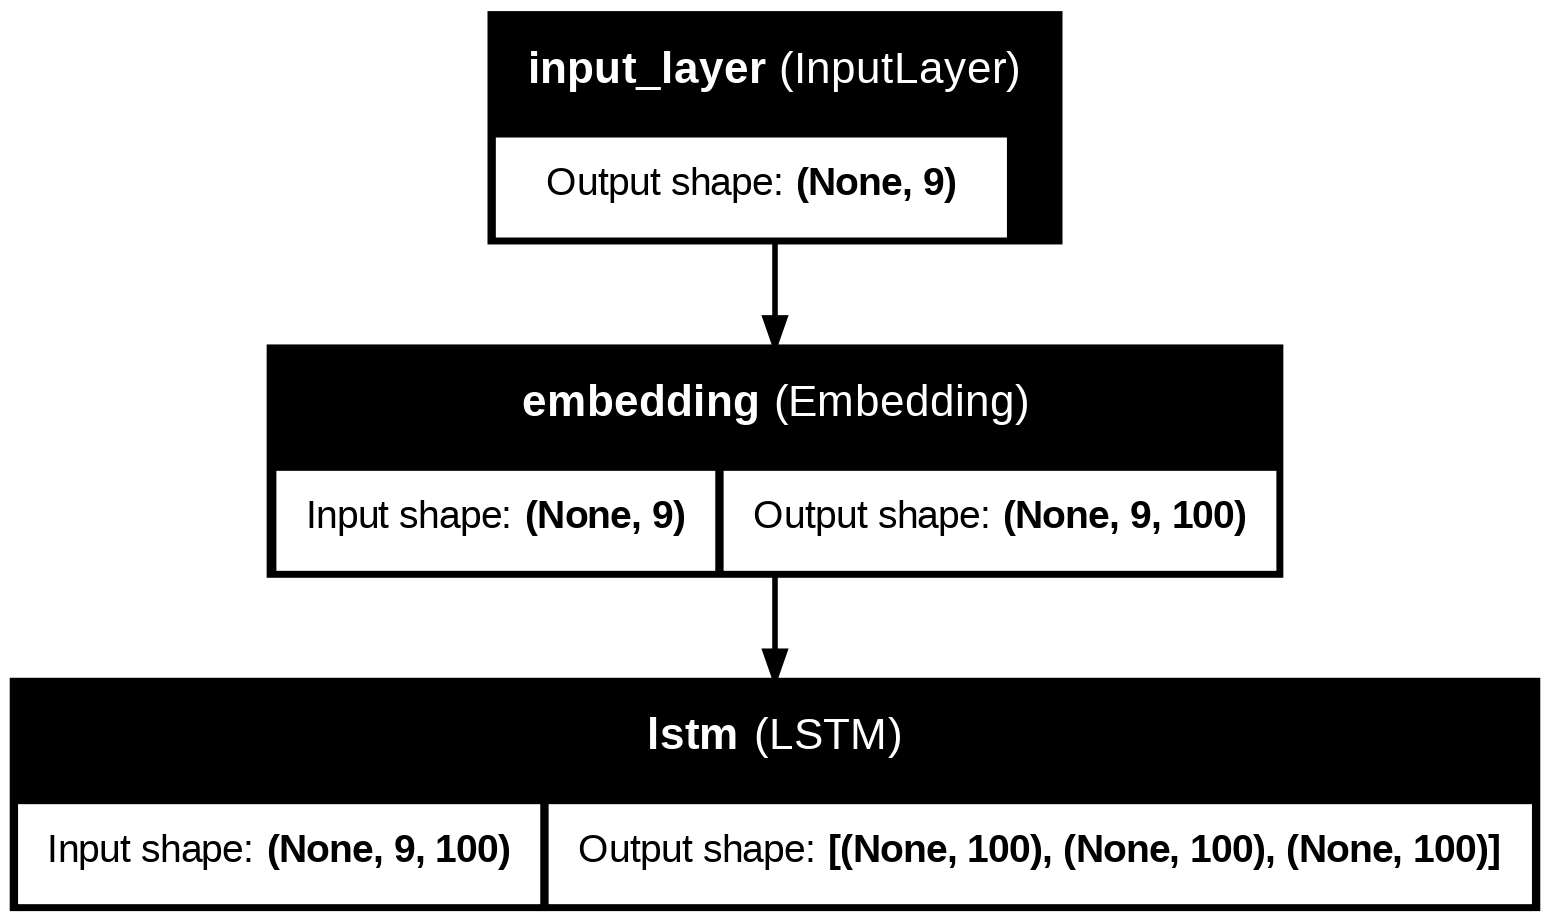

In [ ]:
plot_model(encoder_model, to_file='/model_prd_enc_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
decoder_input_h = Input(shape=(LSTM_NEURONS,))
decoder_input_c = Input(shape=(LSTM_NEURONS,))
decoder_input_states = [decoder_input_h, decoder_input_c]

decoder_input_word = Input(shape=(1,))
decoder_input_word_emb = decoder_embedding_layer(decoder_input_word)

decoder_outputs, h, c = decoder(decoder_input_word_emb, initial_state=decoder_input_states)
decoder_states = [h, c]

outputs = output_dense_layer(decoder_outputs)


In [ ]:

decoder_model = Model([decoder_input_word]+decoder_input_states, [outputs]+decoder_states)
print(decoder_model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    542,800 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 100),  │     80,400 │ embedding_1[1][0… │
│                     │ (None, 100),      │            │ input_layer_2[0]… │
│                     │ (None, 100)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 5428)   │    548,228 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,171,428 (4.47 MB)

 Trainable params: 1,171,428 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

None


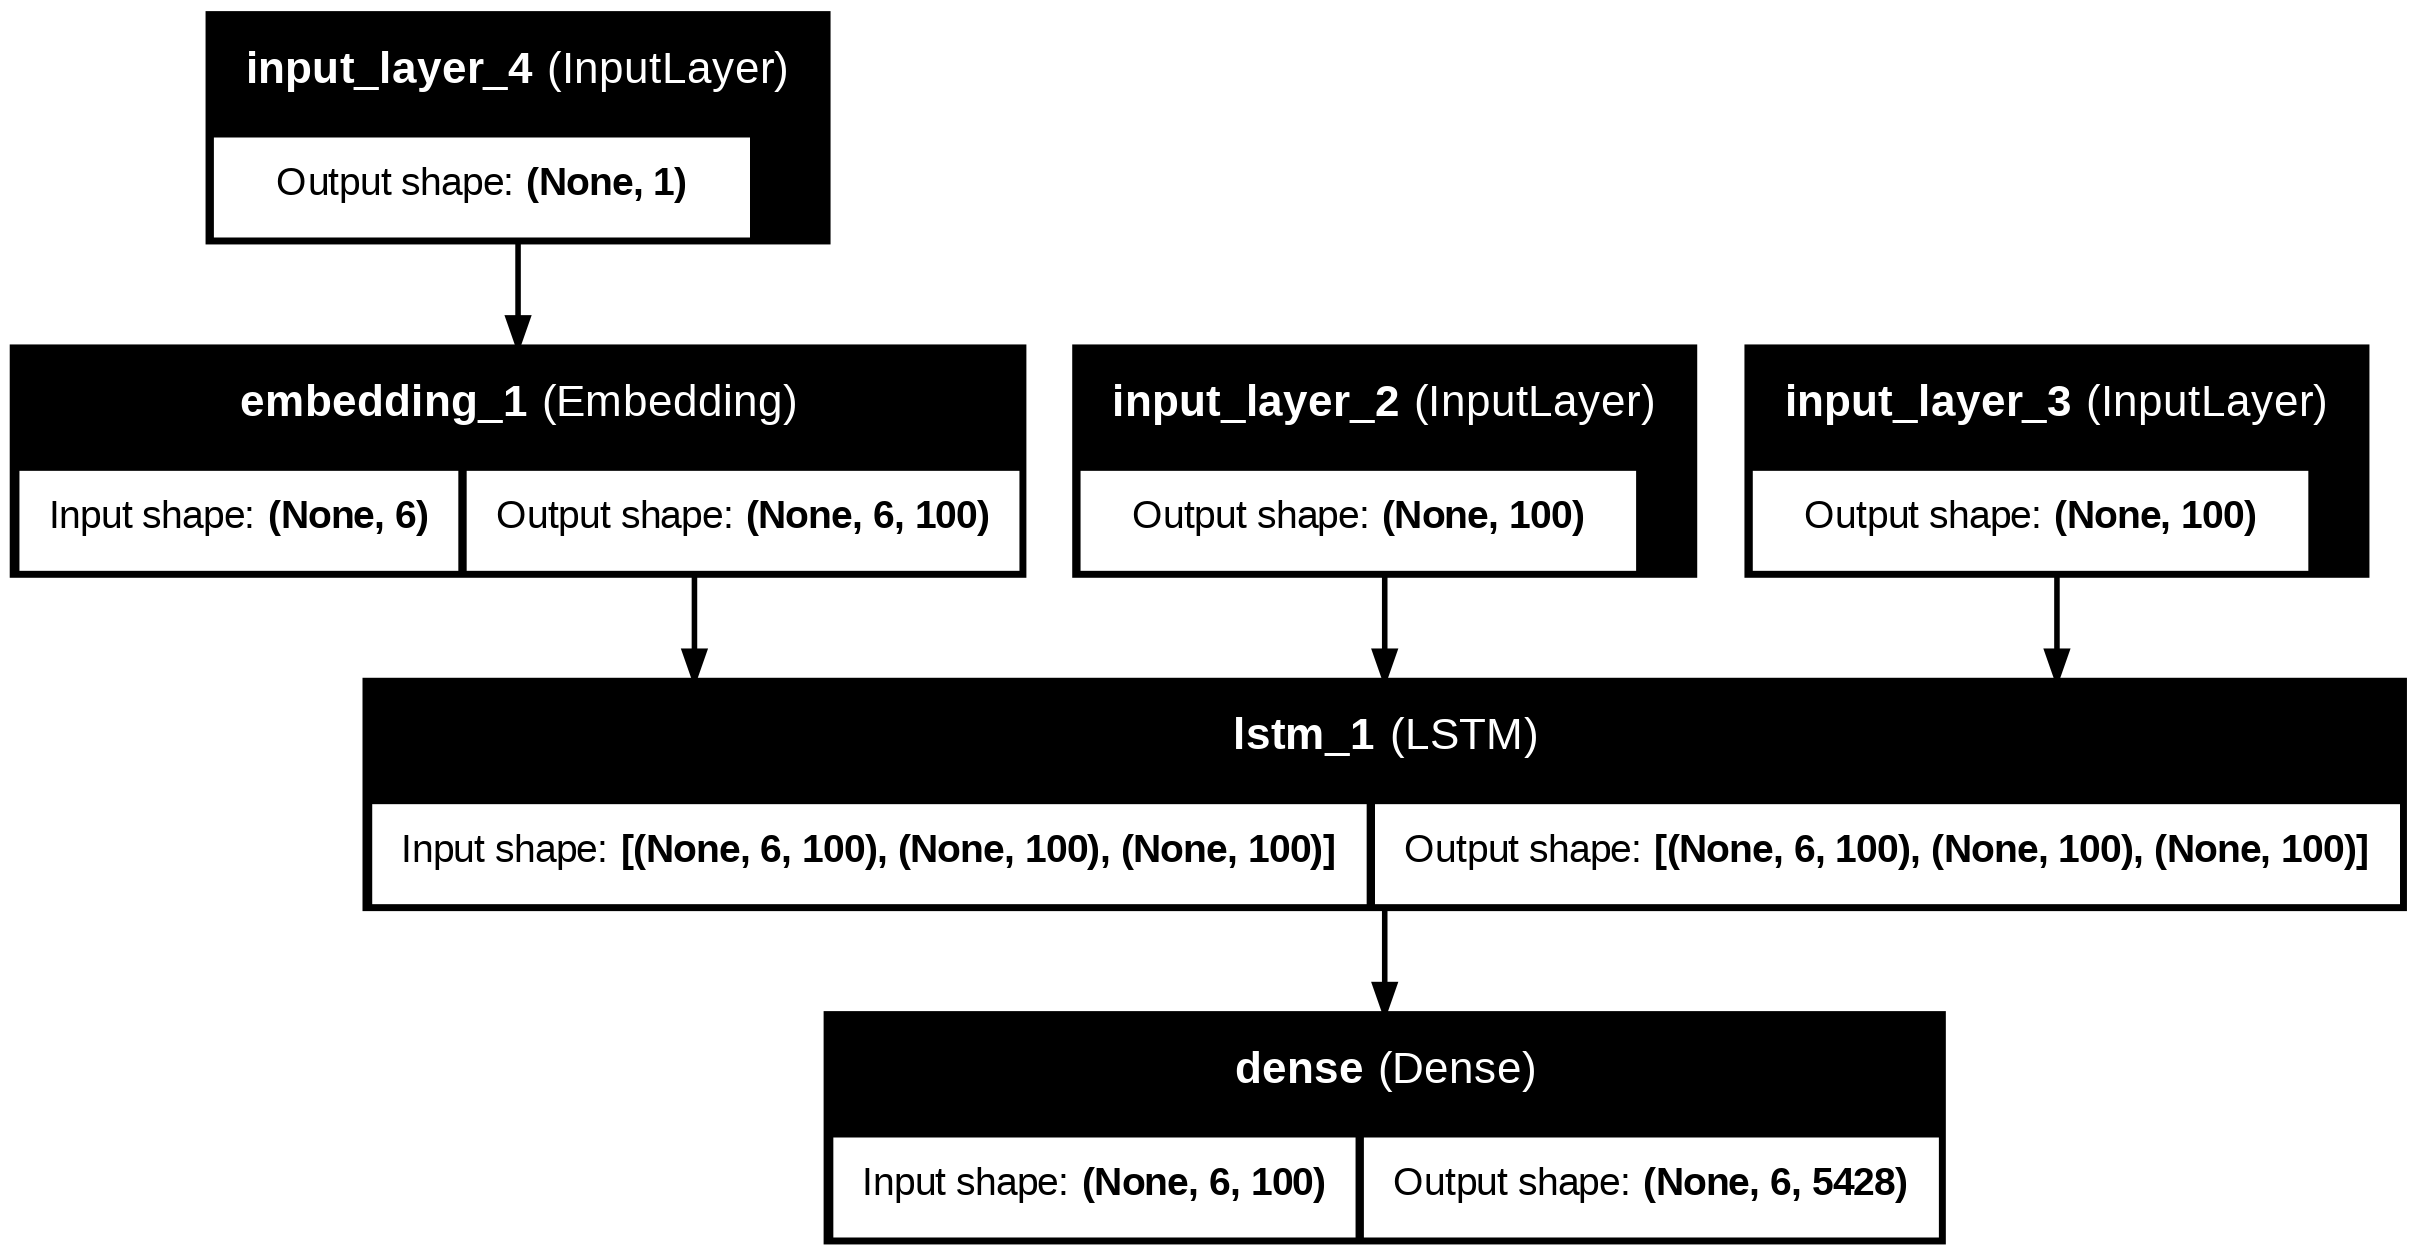

In [ ]:
plot_model(decoder_model, to_file='/model_prd_dec_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
pickle.dump(decoder_model, open('/model_prd_dec.sav', 'wb'))


In [ ]:
from numpy import argmax

index_to_word_input = {v:k for k,v in inputs_word2index.items()}
index_to_word_output = {v:k for k,v in outputs_word2index.items()}

def translate(input_seq):
    states = encoder_model.predict(input_seq)

    sos = outputs_word2index['<sos>']
    eos = outputs_word2index['<eos>']

    output_seq = zeros((1, 1))
    output_seq[0, 0] = sos

    output_sentence = []

    for _ in range(outputs_maxlen):
        output_tokens, h, c = decoder_model.predict([output_seq]+states)
        idx = argmax(output_tokens[0, 0, :])

        if idx == eos:
            break
        word = ''
        if idx > 0:
            word = index_to_word_output[idx]
            output_sentence.append(word)

        states = [h, c]
        output_seq[0, 0] = idx

    return ' '.join(output_sentence)


In [ ]:
from numpy import random

i = random.choice(len(inputs))
print(i)
i = 0
input_seq = encoder_input_sequences[i:i+1]
print(input_seq)
translation = translate(input_seq)

print('Input:', inputs[i])
print('Response:', translation)


2235
[[ 0  0  0  0  0  0  0  0 96]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input: Ve.
Response: it go it.


In [ ]:
def translate_batch(input_batch, max_len=None, batch_size=256):

    if max_len is None:
        max_len = outputs_maxlen


    states = encoder_model.predict(input_batch, batch_size=batch_size, verbose=0)

    B = input_batch.shape[0]
    sos = outputs_word2index['<sos>']
    eos = outputs_word2index['<eos>']


    output_seq = np.full((B, 1), sos, dtype='int32')
    done = np.zeros((B,), dtype=bool)
    decoded_tokens = [[] for _ in range(B)]

    for _ in range(max_len):

        output_probs, h, c = decoder_model.predict([output_seq] + states,
                                                   batch_size=batch_size, verbose=0)

        next_ids = output_probs[:, 0, :].argmax(axis=-1).astype('int32')


        for i, idx in enumerate(next_ids):
            if not done[i]:
                if idx == eos:
                    done[i] = True
                elif idx > 0:
                    decoded_tokens[i].append(index_to_word_output.get(int(idx), ''))


        states = [h, c]
        output_seq[:, 0] = next_ids

        if done.all():
            break

    return [' '.join(toks) for toks in decoded_tokens]


def translate_all(inputs_array, batch_size=256):

    hyps = []
    for start in range(0, len(inputs_array), batch_size):
        batch = inputs_array[start:start+batch_size]
        hyps.extend(translate_batch(batch, batch_size=batch_size))
    return hyps

In [ ]:
hypotheses = translate_all(encoder_input_sequences, batch_size=128)

In [ ]:
hyp_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
hyp_tokenizer.fit_on_texts(hypotheses)

hyp_seq = hyp_tokenizer.texts_to_sequences(hypotheses)


hyp_word2index = hyp_tokenizer.word_index
print('Total unique words in refrence:', len(hyp_word2index))

hyp_numwords = len(hyp_word2index)+1

hyp_maxlen = max(len(s) for s in hyp_seq)
print('Length of longest sentence in input:', hyp_maxlen)

In [ ]:
decoder_hyp_sequences = pad_sequences(hyp_seq, maxlen=hyp_maxlen, padding='post')
print('refseq shape:', decoder_hyp_sequences.shape)
for row in decoder_hyp_sequences:
  print(row)

In [ ]:
print(inputs[1])
print(hypotheses[1])
print(reference[1])

In [ ]:


from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def simple_tok(s: str):

    return  s.strip().split()


refs_tok = [simple_tok(r) for r in reference]
hyps_tok = [simple_tok(h) for h in hypotheses]
input_tok = [len(simple_tok(i)) for i in inputs]


smooth = SmoothingFunction().method3

def avg_sentence_bleu(refs_tok, hyps_tok, weights):
    scores = []

    for ref, hyp in zip(refs_tok, hyps_tok):
        if not hyp:
            scores.append(0.0)
            continue
        scores.append(sentence_bleu(ref, hyp, weights=weights, smoothing_function=smooth))

        #len.append(len(hyp))
    return sum(scores) / len(scores)

def create_plot(refs_tok, hyps_tok, weights):
    scores = []

    for ref, hyp in zip(refs_tok, hyps_tok):
        if not hyp:
            scores.append(0.0)
            continue
        scores.append(sentence_bleu(ref, hyp, weights=weights, smoothing_function=smooth))



    #xpoints = np.array(input_tok)
    #ypoints = np.array(scores)

    input_tok
    scores

    x = np.asarray(input_tok, dtype=float)
    y = np.asarray(scores, dtype=float)
    n = min(len(x), len(y))
    if len(x) != len(y):
        print(f"Warning: length mismatch; truncating to {n}")
        x, y = x[:n], y[:n]

    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]


    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)
    xs = np.linspace(x.min(), x.max(), 100)
    ys = poly(xs)

    y_hat = poly(x)
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, label="Data")
    plt.plot(xs, ys, label=f"Best fit: y = {coef[0]:.4f}x + {coef[1]:.4f}")
    plt.title("LSTM: BLEU Score in relation to Sentence Length")
    plt.xlabel("Token Length")
    plt.ylabel("BLEU Score")
    plt.legend()
    plt.grid(True, linewidth=0.3)
    plt.text(0.05, 0.95, f"$R^2$ = {r2:.4f}", transform=plt.gca().transAxes, va="top")
    plt.tight_layout()
    plt.show()

w_bleu4 = (0.25, 0.25, 0.25, 0.25)
w_bleu2 = (0.5, 0.5, 0.0, 0.0)

#avg_b4 = avg_sentence_bleu(refs_tok, hyps_tok, w_bleu4)
#avg_b2 = avg_sentence_bleu(refs_tok, hyps_tok, w_bleu2)

avg_b4 = avg_sentence_bleu(reference, hypotheses, w_bleu4)
avg_b2 = avg_sentence_bleu(reference, hypotheses, w_bleu2)

create_plot(reference, hypotheses, w_bleu2)
create_plot(reference, hypotheses, w_bleu4)

for i in range(20):
  print(reference[i])
  print(hypotheses[i])

print(f"Avg sentence BLEU-4: {100*avg_b4:.2f}")
print(f"Avg sentence BLEU-2: {100*avg_b2:.2f}")
print(f"Avg sentence BLEU-4: ", avg_b4)
print(f"Avg sentence BLEU-2: ", avg_b2)

for i in range(3):
    s = sentence_bleu(reference[i], hypotheses[i], weights=w_bleu4, smoothing_function=smooth)
    print(f"\nINPUT: {inputs[i]}")
    print(f"REF: {reference[i]}")
    print(f"HYP: {hypotheses[i]}")
    #print(f"LEN: {len[i]}")
    print(f"Sentence BLEU-4: {100*s:.2f}")